In [ ]:
#| default_exp paint

# paint

> Using HACC-hydro star formation history and metallicity information to generate SEDs

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()
from nbdev.showdoc import *
from fastcore.test import *

/home/nramachandra/anaconda3/envs/env_jax/lib/python3.9/site-packages/nbdev/export.py:54: UserWarning: Notebook '/lcrc/project/cosmo_ai/nramachandra/Projects/Hydro_paint/paint_hydro/nbs/index.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [ ]:
#| export
import numpy as np
import math
import sys, os
import fsps
from astropy.cosmology import *
import matplotlib.pylab as plt
# from colossus.cosmology import cosmology
# import haccytrees

In [ ]:
#| export
def autoscale_y(ax,margin=0.1):
    """This function rescales the y-axis based on the data that is visible given the current xlim of the axis.
    ax -- a matplotlib axes object
    margin -- the fraction of the total height of the y-data to pad the upper and lower ylims"""


    def get_bottom_top(line):
        xd = line.get_xdata()
        yd = line.get_ydata()
        lo,hi = ax.get_xlim()
        y_displayed = yd[((xd>lo) & (xd<hi))]
        h = np.max(y_displayed) - np.min(y_displayed)
        bot = np.min(y_displayed)-margin*h
        top = np.max(y_displayed)+margin*h
        return bot,top

    lines = ax.get_lines()
    bot,top = np.inf, -np.inf

    for line in lines:
        new_bot, new_top = get_bottom_top(line)
        if new_bot < bot: bot = new_bot
        if new_top > top: top = new_top

    ax.set_ylim(bot,top)

In [ ]:
#| export
def cosmo_redshifting(DL_Gpc=0.0, # Luminosity distance (LD) in unit of Gpc. If this parameter is not zero, the LD will not be calculated using the Astropy Cosmology package. 
                      cosmo='flat_LCDM', # Choices for the cosmological parameters. The choices are: ['flat_LCDM', 'WMAP5',  'WMAP7', 'WMAP9', 'Planck13', 'Planck15'], similar to the choices available in the  Astropy Cosmology package: https://docs.astropy.org/en/stable/cosmology/#built-in-cosmologies. If 'flat_LCDM' is chosen, the input H0 and Om0 should be provided.
                      H0=70.0, # Hubble constant at z=0.
                      Om0=0.3, # Omega matter at z=0.
                      z=0.01, # Redshift.
                      wave=[], # Wavelength grids of the input spectrum.
                      spec=[]): # Fluxes of the input spectrum.  
    """
    returns redsh_wave: Wavelength grids of the redshifted spectrum
    returns redsh_spec: Fluxes of redshifted spectrum. 
    """

    if DL_Gpc > 0.0:
        DL = DL_Gpc
        DL = DL*3.08568e+27
    else:
        if cosmo=='flat_LCDM' or cosmo==0:
            cosmo1 = FlatLambdaCDM(H0=H0, Om0=Om0)
            DL = cosmo1.luminosity_distance(z)      # in unit of Mpc
        elif cosmo=='WMAP5' or cosmo==1:
            DL = WMAP5.luminosity_distance(z)
        elif cosmo=='WMAP7' or cosmo==2:
            DL = WMAP7.luminosity_distance(z)
        elif cosmo=='WMAP9' or cosmo==3:
            DL = WMAP9.luminosity_distance(z)
        elif cosmo=='Planck13' or cosmo==4:
            DL = Planck13.luminosity_distance(z)
        elif cosmo=='Planck15' or cosmo==5:
            DL = Planck15.luminosity_distance(z)
        #elif cosmo=='Planck18' or cosmo==6:
        #    DL = Planck18.luminosity_distance(z)
        
        DL = DL.value/1.0e+3
        DL = DL*3.08568e+27

    redsh_wave = (1.0+z)*np.asarray(wave)
    cor = 1.0/12.56637061/DL/DL/(1.0+z)           # flux in L_solar cm^-2 A^-1
    cor = cor*3.826e+33                           # flux in erg s^-1 cm^-2 A^-1
    redsh_spec = cor*np.asarray(spec)

    return redsh_wave, redsh_spec

In [ ]:
#| export
def convert_unit_spec_from_ergscm2A(wave, # wavelength
                                    spec, # SEDs
                                    funit='Jy'): #Units
    """
    A function to convert unit of flux from 'erg/s/cm2/A' --> 'erg/s/cm2' or 'Jy'
    """
    if funit=='erg/s/cm2/A' or funit==0:
        spec_new = spec
    elif funit=='erg/s/cm2' or funit==1:
        spec_new = np.asarray(spec)*np.asarray(wave)
    elif funit=='Jy' or funit==2:
        spec_new = np.asarray(spec)*np.asarray(wave)*np.asarray(wave)/1.0e-23/2.998e+18
    else:
        print ("The input funit is not recognized!")
        sys.exit()

    return spec_new

In [ ]:
#| export
def csp_spec_restframe_fit(sp=None, sfh_t=np.linspace(0, 13, 100), sfh_sfr=np.arctan(np.linspace(0, 13, 100)), age=0.0, formed_mass=1.0):
	"""A function for generating model spectrum of an CSP
	:param sp:
		Initialization of FSPS, such as sp=fsps.StellarPopulation()
	:param sfh_form: (default: 4)
		Choice for the parametric SFH model. Options are: (a) 0 for exponentially declining or tau model, (b) 1 for delayed tau model, (c) 2 for log normal model, (d) 3 for Gaussian form, (e) 4 for double power-law model.
	:param formed_mass:
		The total stellar mass formed.
	"""

	# make grid of SFH:
	# sfh_t, sfh_sfr = construct_SFH(sfh_form=sfh_form,t0=t0,tau=tau,alpha=alpha,beta=beta,age=age,formed_mass=formed_mass)
        

	sp.params["sfh"] = 3
	sp.set_tabular_sfh(sfh_t, sfh_sfr)
	wave, spec0 = sp.get_spectrum(peraa=True,tage=age) ## spectrum in L_sun/AA

	mass0 = sp.stellar_mass
	dust_mass0 = sp.dust_mass

	norm = formed_mass/mass0
	spec = spec0*norm
	dust_mass = dust_mass0*norm

	SFR = sp.sfr
	mass = formed_mass

	return SFR,mass,wave,spec,dust_mass


def generate_modelSED_spec(sp=None,imf_type=1,duste_switch=1,add_neb_emission=1, dust_law=1, sfh_form=3, sfh_t=np.linspace(0, 13, 100), sfh_sfr=np.arctan(np.linspace(0, 13, 100)), 
	add_agn=0,add_igm_absorption=0,igm_type=0,cosmo='flat_LCDM',H0=70.0,Om0=0.3,gas_logu=-2.0,params_val={'log_mass':0.0,
	'z':0.001,'log_fagn':-3.0,'log_tauagn':1.0,'log_qpah':0.54,'log_umin':0.0,'log_gamma':-2.0,'dust1':0.5,'dust2':0.5,
	'dust_index':-0.7,'log_age':1.0,'log_alpha':0.1,'log_beta':0.1,'log_t0':0.4,'log_tau':0.4,'logzsol':0.0}):
	"""Function for generating a model spectrum given some parameters.
	:param sp: (optional, default: None)
		Initialization of FSPS, such as `sp=fsps.StellarPopulation()`. This is intended for rapid generation of model spectra from FSPS.
		However, this input is optional. If sp=None, FSPS will be called everytime this function is called.
	:param imf_type:
		Choice for the IMF. Choices are: 0 for Salpeter(1955), 1 for Chabrier(2003), and 2 for Kroupa(2001).
	:param duste_switch:
		Choice for switching on (value: 1) or off (value: 0) the dust emission modeling.
	:param add_neb_emission:
		Choice for switching on (value: 1) or off (value: 0) the nebular emission modeling.
	:param dust_law:
		Choice for the dust attenuation law. Options are: 0 for Charlot & Fall (2000) and 1 for Calzetti et al. (2000).
	:param sfh_form:
		Choice for the parametric SFH model. Options are: 0 for exponentially declining or tau model, 1 for delayed tau model, 2 for log normal model, 3 for Gaussian form, and 4 for double power-law model.
	:param add_agn:
		Choice for turning on (value: 1) or off (value: 0) the AGN dusty torus modeling.
	:param add_igm_absorption: 
		Choice for turning on (value: 1) or off (value: 0) the IGM absorption modeling.
	:param igm_type:
		Choice for the IGM absorption model. Options are: 0 for Madau (1995) and 1 for Inoue+(2014).
	:param cosmo: 
		Choices for the cosmology. Options are: (1)'flat_LCDM' or 0, (2)'WMAP5' or 1, (3)'WMAP7' or 2, (4)'WMAP9' or 3, (5)'Planck13' or 4, (6)'Planck15' or 5.
		These options are similar to the choices available in the `Astropy Cosmology <https://docs.astropy.org/en/stable/cosmology/#built-in-cosmologies>`_ package.
	:param H0:
		The Hubble constant at z=0. Only relevant when cosmo='flat_LCDM' is chosen.
	:param Om0:
		The Omega matter at z=0.0. Only relevant when cosmo='flat_LCDM' is chosen.
	:param gas_logu:
		Gas ionization parameter in logarithmic scale.
	:param param_val:
		Dictionary of the input values of the parameters. Should folllow the structure given in the default set. 
		Summary of the parameters are tabulated in Table 1 of `Abdurro'uf et al. (2021) <https://ui.adsabs.harvard.edu/abs/2021arXiv210109717A/abstract>`_.
	:returns spec_SED:
		Array containing output model spectrum. It consists of spec_SED['wave'], which is the wavelengths grids, and spec_SED['flux'], which is the fluxes or the spectrum. 
	"""
	
	# input parameters:
	formed_mass = math.pow(10.0,params_val['log_mass'])
	age = math.pow(10.0,params_val['log_age'])
	tau = math.pow(10.0,params_val['log_tau'])
	t0 = math.pow(10.0,params_val['log_t0'])
	alpha = math.pow(10.0,params_val['log_alpha'])
	beta = math.pow(10.0,params_val['log_beta'])

	if sp == None:
		import fsps 
		sp = fsps.StellarPopulation(zcontinuous=1, imf_type=imf_type)

	sp.params['imf_type'] = imf_type

	# dust emission:
	if duste_switch == 1:
		sp.params["add_dust_emission"] = True
		sp.params["duste_gamma"] = math.pow(10.0,params_val['log_gamma']) 
		sp.params["duste_umin"] = math.pow(10.0,params_val['log_umin'])
		sp.params["duste_qpah"] = math.pow(10.0,params_val['log_qpah'])
	elif duste_switch == 0:
		sp.params["add_dust_emission"] = False

	# nebular emission:
	if add_neb_emission == 1:
		sp.params["add_neb_emission"] = True
		sp.params['gas_logu'] = gas_logu
	elif add_neb_emission == 0:
		sp.params["add_neb_emission"] = False

	# AGN:
	if add_agn == 1:
		sp.params["fagn"] = math.pow(10.0,params_val['log_fagn'])
		sp.params["agn_tau"] = math.pow(10.0,params_val['log_tauagn'])
	elif add_agn == 0:
		sp.params["fagn"] = 0

	# dust atenuation:
	# if dust_law==0:
	# 	sp.params["dust_type"] = 0  
	# 	sp.params["dust_tesc"] = 7.0
	# 	sp.params["dust_index"] = params_val['dust_index']
	# 	dust1_index = -1.0
	# 	sp.params["dust1_index"] = dust1_index
	# 	sp.params["dust1"] = params_val['dust1']
	# 	sp.params["dust2"] = params_val['dust2']
	if dust_law==1:
		sp.params["dust_type"] = 2  
		sp.params["dust1"] = 0
		sp.params["dust2"] = params_val['dust2']
	else: print("Check dust law")

	# other parameters:
	sp.params["logzsol"] = params_val['logzsol'] 
	sp.params['gas_logz'] = params_val['logzsol']
	sp.params['tage'] = age
    
    
	# EMISSION LINE WIDTH parameters:
	sp.params['smooth_velocity']=True
	sp.params['smooth_lsf']=True
	sp.params['sigma_smooth']=0.001

	# generate the SED:
	if sfh_form==0 or sfh_form==1:
		print('Not implemented anymore')
# 		if sfh_form==0:
# 			sp.params["sfh"] = 1
# 		elif sfh_form==1:
# 			sp.params["sfh"] = 4
# 		sp.params["const"] = 0
# 		sp.params["sf_start"] = 0
# 		sp.params["sf_trunc"] = 0
# 		sp.params["fburst"] = 0
# 		sp.params["tburst"] = 30.0
# 		sp.params["tau"] = tau
# 		#sp.params["tage"] = age

# 		wave, extnc_spec = sp.get_spectrum(peraa=True,tage=age) ## spectrum in L_sun/AA
# 		# get model mass:
# 		mass = sp.stellar_mass
# 		# get dust mass: 
# 		#dust_mass0 = sp.dust_mass    # in solar mass/norm

# 		# normalization:
# 		norm0 = formed_mass/mass
# 		extnc_spec = extnc_spec*norm0


	elif sfh_form==2 or sfh_form==3 or sfh_form==4:
		sp.params["sfh"] = 3
		SFR_fSM,mass,wave,extnc_spec,dust_mass = csp_spec_restframe_fit(sp=sp, sfh_t=sfh_t, sfh_sfr=sfh_sfr, age=age, formed_mass=formed_mass)
		
	# redshifting
	redsh_wave,redsh_spec0 = cosmo_redshifting(cosmo=cosmo,H0=H0,Om0=Om0,z=params_val['z'],wave=wave,spec=extnc_spec)

	# IGM absorption:
	redsh_spec = redsh_spec0
	if add_igm_absorption == 1:
		if igm_type==0:
			trans = igm_att_madau(redsh_wave,params_val['z'])
			redsh_spec = redsh_spec0*trans
		elif igm_type==1:
			trans = igm_att_inoue(redsh_wave,params_val['z'])
			redsh_spec = redsh_spec0*trans

	spec_SED = {}
	spec_SED['wave'] = redsh_wave
	spec_SED['flux'] = redsh_spec

	return spec_SED


def generate_modelSED_spec_decompose(sp=None,imf=1, duste_switch=1,add_neb_emission=1,dust_law=1,add_agn=1,
	add_igm_absorption=0,igm_type=0,sfh_form=3, sfh_t=np.linspace(0, 13, 100), sfh_sfr=np.arctan(np.linspace(0, 13, 100)), funit='erg/s/cm2/A',cosmo='flat_LCDM',H0=70.0,Om0=0.3,
	gas_logu=-2.0,params_val={'log_mass':0.0,'z':0.001,'log_fagn':-3.0,'log_tauagn':1.0,'log_qpah':0.54,'log_umin':0.0,
	'log_gamma':-2.0,'dust1':0.5,'dust2':0.5,'dust_index':-0.7,'log_age':1.0,'log_alpha':0.1,'log_beta':0.1,'log_t0':0.4,
	'log_tau':0.4,'logzsol':0.0}):
	"""A function for generating model spectroscopic SED and decompose the SED into its components.
	:param funit:
		Flux unit. Options are: [0/'erg/s/cm2/A', 1/'erg/s/cm2', 2/'Jy']
	
	"""

	# allocate memories:
	spec_SED = {}
	spec_SED['wave'] = []
	spec_SED['flux_total'] = []
	spec_SED['flux_stellar'] = []
	spec_SED['flux_nebe'] = []
	spec_SED['flux_duste'] = []
	spec_SED['flux_agn'] = []

	# generate model spectrum: total
	spec_SED_tot = generate_modelSED_spec(sp=sp,imf_type=imf,duste_switch=duste_switch,add_neb_emission=add_neb_emission,dust_law=dust_law,
					sfh_form=sfh_form, sfh_t=sfh_t, sfh_sfr=sfh_sfr, add_agn=add_agn,add_igm_absorption=add_igm_absorption,igm_type=igm_type,cosmo=cosmo,H0=H0,Om0=Om0,gas_logu=gas_logu,params_val=params_val)
	spec_SED['wave'] = spec_SED_tot['wave']
	spec_SED['flux_total'] = convert_unit_spec_from_ergscm2A(spec_SED_tot['wave'],spec_SED_tot['flux'],funit=funit)

	spec_SED_temp = generate_modelSED_spec(sp=sp,imf_type=imf,duste_switch=0,add_neb_emission=0,dust_law=dust_law,sfh_form=sfh_form, sfh_t=sfh_t, sfh_sfr=sfh_sfr, add_agn=0,
					add_igm_absorption=add_igm_absorption,igm_type=igm_type,cosmo=cosmo,H0=H0,Om0=Om0,gas_logu=gas_logu,params_val=params_val)
	spec_flux_stellar = spec_SED_temp['flux']
	spec_SED['flux_stellar'] = convert_unit_spec_from_ergscm2A(spec_SED_temp['wave'],spec_flux_stellar,funit=funit)

	# get nebular emission:
	if add_neb_emission == 1:
		add_neb_emission_temp  = 1
		spec_SED_temp1 = generate_modelSED_spec(sp=sp,imf_type=imf,duste_switch=0,add_neb_emission=add_neb_emission_temp,
							dust_law=dust_law,sfh_form=sfh_form, sfh_t=sfh_t, sfh_sfr=sfh_sfr, add_agn=0,add_igm_absorption=add_igm_absorption,igm_type=igm_type,
							cosmo=cosmo,H0=H0,Om0=Om0,gas_logu=gas_logu,params_val=params_val)
		add_neb_emission_temp  = 0
		spec_SED_temp2 = generate_modelSED_spec(sp=sp,imf_type=imf,duste_switch=0,add_neb_emission=add_neb_emission_temp,
							dust_law=dust_law,sfh_form=sfh_form, sfh_t=sfh_t, sfh_sfr=sfh_sfr, add_agn=0,add_igm_absorption=add_igm_absorption,igm_type=igm_type,
							cosmo=cosmo,H0=H0,Om0=Om0,gas_logu=gas_logu,params_val=params_val)
		spec_flux_nebe = spec_SED_temp1['flux'] - spec_SED_temp2['flux']
		spec_SED['flux_nebe'] = convert_unit_spec_from_ergscm2A(spec_SED_temp['wave'],spec_flux_nebe,funit=funit)

	# get dust emission:
	if duste_switch == 1:
		duste_switch_temp = 0
		spec_SED_temp = generate_modelSED_spec(sp=sp,imf_type=imf,duste_switch=duste_switch_temp,add_neb_emission=add_neb_emission,
							dust_law=dust_law,sfh_form=sfh_form, sfh_t=sfh_t, sfh_sfr=sfh_sfr, add_agn=add_agn,add_igm_absorption=add_igm_absorption,igm_type=igm_type,
							cosmo=cosmo,H0=H0,Om0=Om0,gas_logu=gas_logu,params_val=params_val)
		spec_flux_duste = spec_SED_tot['flux'] - spec_SED_temp['flux']
		spec_SED['flux_duste'] = convert_unit_spec_from_ergscm2A(spec_SED_temp['wave'],spec_flux_duste,funit=funit)
	# get AGN emission:
	if add_agn == 1:
		add_agn_temp = 0
		spec_SED_temp = generate_modelSED_spec(sp=sp,imf_type=imf,duste_switch=duste_switch,add_neb_emission=add_neb_emission,
							dust_law=dust_law,sfh_form=sfh_form, sfh_t=sfh_t, sfh_sfr=sfh_sfr, add_agn=add_agn_temp,add_igm_absorption=add_igm_absorption,
							igm_type=igm_type,cosmo=cosmo,H0=H0,Om0=Om0,gas_logu=gas_logu,params_val=params_val)
		spec_flux_agn = spec_SED_tot['flux'] - spec_SED_temp['flux']
		spec_SED['flux_agn'] = convert_unit_spec_from_ergscm2A(spec_SED_temp['wave'],spec_flux_agn,funit=funit)


	return spec_SED

(1e-06, 10.0)

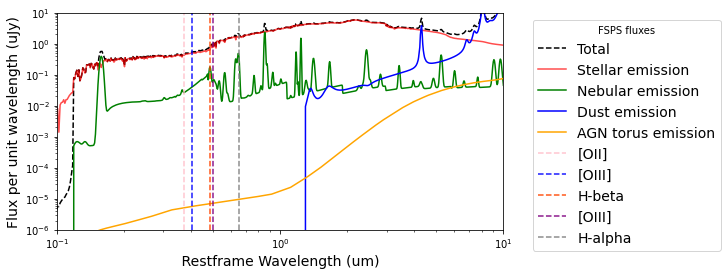

In [ ]:
#| hide
import matplotlib.pylab as plt
f, a = plt.subplots(1, 1, figsize = (8, 4))


if True:

    obs_spec = generate_modelSED_spec_decompose(sp=None,imf=1, duste_switch=1,add_neb_emission=1,dust_law=1,add_agn=1, 
                                                add_igm_absorption=0,igm_type=0,sfh_form=3, 
                                                sfh_t=np.linspace(0, 13, 100), sfh_sfr=np.arctan(np.linspace(0, 13, 100)), 
                                                funit='Jy',cosmo='flat_LCDM',H0=70.0,Om0=0.3,
                                                gas_logu=-2.0,params_val={'log_mass':9.0,'z':0.3,'log_fagn':-3.0,'log_tauagn':1.0,
                                                                          'log_qpah':0.54,'log_umin':0.0,
                                                                          'log_gamma':-2.0,'dust1':0.1,'dust2':0.5,'dust_index':-0.7,
                                                                          'log_age':1.0,'log_alpha':0.1,'log_beta':0.1,'log_t0':0.4,
                                                                          'log_tau':0.4,'logzsol':0.0})

    a.plot(obs_spec['wave']/1e4, 1e6*obs_spec['flux_total'], color = 'k', alpha=1.0, ls = 'dashed', label='Total');
    a.plot(obs_spec['wave']/1e4, 1e6*obs_spec['flux_stellar'], color = 'r', alpha=0.7, label='Stellar emission');
    a.plot(obs_spec['wave']/1e4, 1e6*obs_spec['flux_nebe'], color = 'g', alpha=1.0, label='Nebular emission');
    a.plot(obs_spec['wave']/1e4, 1e6*obs_spec['flux_duste'], color = 'b', alpha=1.0, label='Dust emission');
    a.plot(obs_spec['wave']/1e4, 1e6*obs_spec['flux_agn'], color = 'orange', alpha=1.0, label='AGN torus emission');

    
a.axvline(x=3727/1e4, label = '[OII]', linestyle='dashed', alpha=0.9, color='pink')
a.axvline(x=4050/1e4, label = '[OIII]', linestyle='dashed', alpha=0.9, color='blue')
a.axvline(x=4861/1e4, label = 'H-beta', linestyle='dashed', alpha=0.9, color='orangered')
a.axvline(x=5007/1e4, label = '[OIII]', linestyle='dashed', alpha=0.9, color='purple')
a.axvline(x=6563/1e4, label = 'H-alpha', linestyle='dashed', alpha=0.9, color='gray')

a.set_ylabel('Flux per unit wavelength (uJy)', fontsize=14)
a.set_xlabel(' Restframe Wavelength (um) ', fontsize=14)

a.set_xscale('log')
a.set_yscale('log')


plt.legend(title='FSPS fluxes', bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=14)

# plt.xlim(8e2, 2e4)
# a.set_xlim(1000, 30000)
a.set_xlim(0.1, 10)
a.set_ylim(1e-6, 1e1)
# autoscale_y(a,margin=0.1)